# SpikeInterface DEMO v0.101 - Neurotech - Aussois - May 2024

For this demo we will use a small file provided by Eduarda Centeno, Arthur Leblois and Aude Retailleau from IMN lab in Bordeaux.
It is a recording from a zebra finch for testing the probe ASSY-236-H5 from cambridge neurotech.
The recording system is the openephys usb3 board.
This file is only for testing or teaching purposes.


# Table of contents

* [0. Preparation](#preparation)
* [1. Reading recording and sorting](#loading)
* [2. Preprocessing](#preprocessing)
* [3. Saving and loading SpikeInterface objects](#save-load)
* [4. Data compression](#compression)
* [5. Postprocessing and SortginAnalyzer](#sortinganalyzer)
* [6. Validation and curation](#curation)
* [7. Viewers](#viewers)
* [8. Spike sorting comparison](#comparison)
* [9. Exporters](#exporters)

# 0. Preparation <a class="anchor" id="preparation"></a>

### Download the ephys data



In [1]:
# TO BE discuss
import spikeinterface.full as si


In [2]:
print(f"SpikeInterface version: {si.__version__}")

SpikeInterface version: 0.101.0


In [3]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

import warnings
warnings.simplefilter("ignore")

# %matplotlib widget
%matplotlib inline

# 1. Reading recording and sorting <a class="anchor" id="loading"></a>

In [4]:
base_folder = Path('/home/samuel/DataSpikeSorting/Aussois_SI_tutorial/')
# base_folder = Path('/data_local/DataSpikeSorting/Aussois_SI_tutorial')
oe_folder = base_folder / 'openephys_recording/2023-08-23_15-56-05'


In [5]:
full_raw_rec = si.read_openephys(oe_folder)


The `read_openephys()` function returns a `Recording` (or `RecordingExtractor`) object. We can print it to visualize some of its properties:

In [6]:
full_raw_rec

OpenEphysBinaryRecordingExtractor: 72 channels - 30.0kHz - 1 segments - 9,000,000 samples 
                                   300.00s (5.00 minutes) - int16 dtype - 1.21 GiB

`spikeinterface.extractors` integrate many readers:

  * `read_nwb()`
  * `read_blackrock()`
  * `read_spikeglx()`
  * ...


For a full list see the doc TODO link

A `RecordingExtractor` object extracts information about channel ids, channel locations (if present), the sampling frequency of the recording, and the extracellular traces (when prompted). The `NwbRecordingExtractor` is designed specifically for NWB files.

Here we retrieve information from the recording using the built-in functions from the RecordingExtractor:

SpikeInterface supports multi-segment recordings. A segment is a contiguous piece of data, and sometimes recordings can be made of multiple acquisitions, for examples a baseline, a stimulation phase, and a post recording. In such cases, the recording object will be made of multiple segments and be treated as such over the pipeline.

The `get_traces()` function returns a TxN numpy array where N is the number of channel ids passed in (all channel ids are passed in by default) and T is the number of frames (determined by start_frame and end_frame).

In [12]:
fs = full_raw_rec.get_sampling_frequency()
trace_snippet = full_raw_rec.get_traces(start_frame=int(fs*0), end_frame=int(fs*2))

In [14]:
print('Traces shape:', trace_snippet.shape)

Traces shape: (60000, 72)


Before moving on with the analysis, we have to load the probe information. For this we will use the [ProbeInterface](https://probeinterface.readthedocs.io/en/main/index.html) package. 

ProbeInterface allows to easily create, manipulate, and visualize neural probes. Moreover, it comes with a wide range of IO functions to import and export existing formats. Finally, we have created a public library of commercial probes (https://github.com/SpikeInterface/probeinterface_library) that can be retrieved with a single line of code.

Let's import `probeinterface`, download the probe and plot it!

In [12]:
import probeinterface as pi
from probeinterface.plotting import plot_probe

In [13]:
manufacturer = 'cambridgeneurotech'
probe_name = 'ASSY-236-H5'

probe = pi.get_probe(manufacturer, probe_name)
print(probe)

ASSY-236-H5 - cambridgeneurotech - 64ch - 1shanks


In most experiments, the neural probe has a connector, that is interfaced to an headstage, which in turn connects to the acquisition system. This *pathway* usually results in a channel remapping, which means that the order of the contacts on the probe is different than the order of the recorded traces.

`probeinterface` provides a growing collection of common pathways that can be loaded directly to wire a device and apply the correct channel mapping:

In [14]:
pi.get_available_pathways()

['H32>RHD2132',
 'ASSY-156>RHD2164',
 'ASSY-116>RHD2132',
 'ASSY-77>Adpt.A64-Om32_2x-sm-NN>RHD2164',
 'ASSY-77>Adpt.A64-Om32_2x-sm-NN>two_RHD2132',
 'cambridgeneurotech_mini-amp-64']

In [15]:
probe.wiring_to_device('cambridgeneurotech_mini-amp-64')

(-50.0, 500.0)

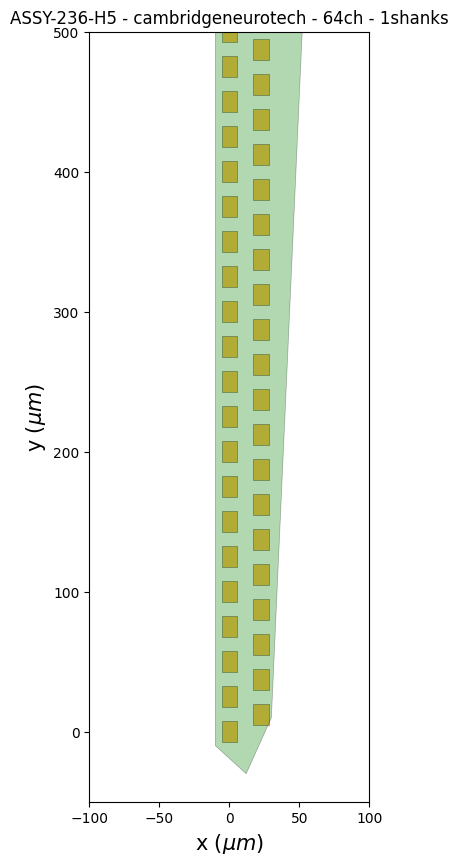

In [16]:
fig, ax = plt.subplots(figsize=(14, 10))
plot_probe(probe, ax=ax)
ax.set_xlim(-100, 100)
ax.set_ylim(-50, 500)

(-50.0, 300.0)

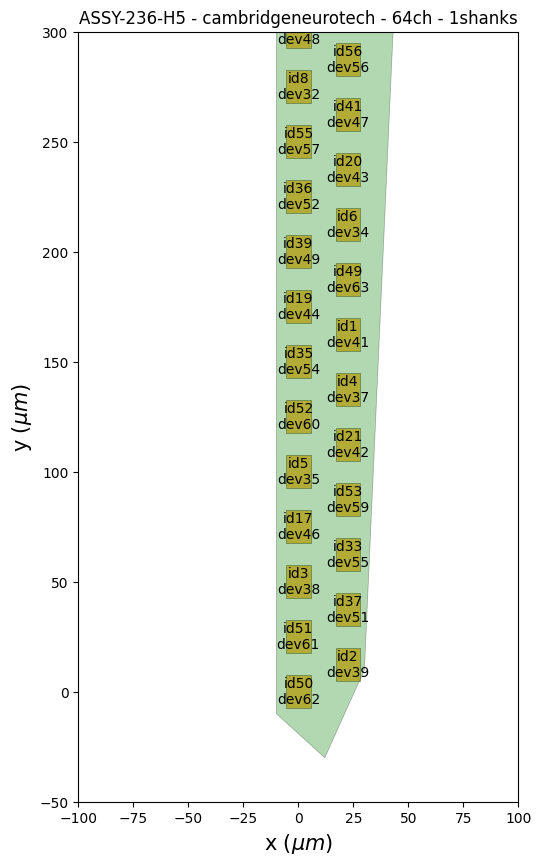

In [17]:
fig, ax = plt.subplots(figsize=(14, 10))
plot_probe(probe, ax=ax, with_contact_id=True, with_device_index=True,)
ax.set_xlim(-100, 100)
ax.set_ylim(-50, 300)

The probe now has contact ids `id#` and device ids `dev#`! We can also visualize the probe information as a `pandas` dataframe:

In [18]:
# MOVE to handon
probe.to_dataframe(complete=True).loc[:, ["contact_ids", "shank_ids", "device_channel_indices"]]

,contact_ids,shank_ids,device_channel_indices
0,1,,41
1,2,,39
2,3,,38
3,4,,37
4,5,,35
...,...,...,...
59,60,,4
60,61,,3
61,62,,2
62,63,,1


When loading the probe, the device indices (and all the other contact properties) are automatically sorted.
And very importantly the recording is reduce to 644 channels!

In [19]:
raw_rec = full_raw_rec.set_probe(probe)
raw_rec

ChannelSliceRecording: 64 channels - 30.0kHz - 1 segments - 9,000,000 samples 
                       300.00s (5.00 minutes) - int16 dtype - 1.07 GiB

In [20]:
# TODO remove
probe_rec = raw_rec.get_probe()
probe_rec.to_dataframe(complete=True).loc[:, ["contact_ids", "device_channel_indices"]]

,contact_ids,device_channel_indices
0,64,0
1,63,1
2,62,2
3,61,3
4,60,4
...,...,...
59,53,59
60,52,60
61,51,61
62,50,62


We can now visualize the channel_id (channel name) from open ephys.

(-50.0, 300.0)

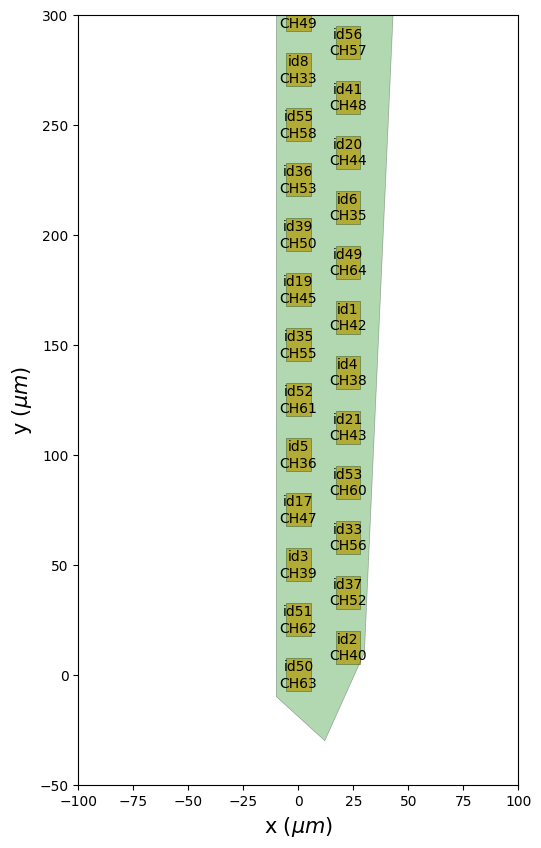

In [22]:
fig, ax = plt.subplots(figsize=(15, 10))
si.plot_probe_map(raw_rec, with_channel_ids=True, with_contact_id=True, ax=ax)
ax.set_xlim(-100, 100)
ax.set_ylim(-50, 300)

The `widgets` module includes several convenient plotting functions that can be used to explore the data:

In [25]:
%matplotlib widget
si.plot_traces(raw_rec, backend="ipywidgets", mode='map')

AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

### Properties 

`RecordingExtractor` object can have *properties*. A property is a piece of information attached to a channel, e.g. group or location.

Similarly, for `SortingExtractor` objects (that we'll cover later), anything related to a unit can be stored as a property. 

We can check which properties are in the extractor as follows:

In [29]:
print("Properties:\n", list(raw_rec.get_property_keys()))

Properties:
 ['gain_to_uV', 'offset_to_uV', 'channel_name', 'contact_vector', 'location', 'group']


Let's add some new properties! 
The first 192 channels are in the CA1 area, the second 192 are in the CA3 area:

In [30]:
# REMOVE
brain_area_property_values = ['CA1']*32 + ['CA3']*32
print(brain_area_property_values)

['CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3']


In [31]:
# REMOVE
raw_rec.set_property(key='brain_area', values=brain_area_property_values)

We can also specify a property on a subset of channels. In this case, the non-specified channels will be filled empty values:

In [32]:
raw_rec.set_property(key='quality', values=["good"]*(raw_rec.get_num_channels() - 3),
                           ids=raw_rec.get_channel_ids()[:-3])

In [33]:
raw_rec.get_property("quality")[-10:]

array(['good', 'good', 'good', 'good', 'good', 'good', 'good', '', '', ''],
      dtype='<U4')

In [34]:
print("Properties after adding custom properties:\n", list(raw_rec.get_property_keys()))

Properties after adding custom properties:
 ['gain_to_uV', 'offset_to_uV', 'channel_name', 'contact_vector', 'location', 'group', 'brain_area', 'quality']


### Annotations

*Annotations* can be attached to any object and they can carry any information related to the recording or sorting objects.

Let's add an annotation about this tutorial:

In [36]:
raw_rec.annotate(description="Dataset for SI tutorial")

In [37]:
print(raw_rec.get_annotation_keys())

['is_filtered', 'probes_info', 'probe_0_planar_contour', 'description']


# 2. Preprocessing <a class="anchor" id="preprocessing"></a>


Now that the probe information is loaded we can do some preprocessing using `preprocessing` module.

We can filter the recordings, rereference the signals to remove noise, discard noisy channels, whiten the data, remove stimulation artifacts, etc. (more info [here](https://spiketoolkit.readthedocs.io/en/latest/preprocessing_example.html)).

For this notebook, let's filter the recordings and apply common median reference (CMR). All preprocessing modules return new `RecordingExtractor` objects that apply the underlying preprocessing function. This allows users to access the preprocessed data in the same way as the raw data.

Below, we bandpass filter the recording and apply common median reference to the original recording:

In [26]:
recording_f = si.bandpass_filter(raw_rec, freq_min=300, freq_max=9000)

Let's now apply Common Median Reference (CMR):

In [27]:
recording_cmr = si.common_reference(recording_f, reference='global', operator='median')

We can plot the traces after applying CMR:

In [28]:
w = si.plot_traces({"filt": recording_f, "common": recording_cmr}, mode='map',
                        time_range=[10, 10.1],
                        backend="ipywidgets")

AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

In [30]:
w = si.plot_traces({"filt": recording_f, "common": recording_cmr}, mode='line',
                        time_range=[10, 10.1],
                        backend="ephyviewer")

In [32]:
# TODO remove bad channel!!!!

## Take only 5 min. for demo

Since we are going to spike sort the data, let's first cut out a 5-minute recording, to speed up computations.

We can easily do so with the `frame_slice()` function:

In [44]:
fs = recording_cmr.get_sampling_frequency()
recording_sub = recording_cmr.frame_slice(start_frame=0*fs, end_frame=300*fs)
recording_sub

FrameSliceRecording: 64 channels - 30.0kHz - 1 segments - 9,000,000 samples 
                     300.00s (5.00 minutes) - int16 dtype - 1.07 GiB

In [46]:
raw_rec_sub = raw_rec.frame_slice(start_frame=0*fs, end_frame=300*fs)
raw_rec_sub

FrameSliceRecording: 64 channels - 30.0kHz - 1 segments - 9,000,000 samples 
                     300.00s (5.00 minutes) - int16 dtype - 1.07 GiB

# 3. Saving and loading SpikeInterface objects <a class="anchor" id="save-load"></a>

All operations in SpikeInterface are *lazy*, meaning that they are not performed if not needed. This is why the creation of our filter recording was almost instantaneous. However, to speed up further processing, we might want to **save** it to a file and perform those operations (eg. filters, CMR, etc.) at once. 


TODO simplify what is inside

In [47]:
job_kwargs = dict(n_jobs=-1, chunk_duration="1s", progress_bar=True)

In [48]:
if (base_folder / "preprocessed").is_dir():
    recording_saved = si.load_extractor(base_folder / "preprocessed")
else:
    recording_saved = recording_sub.save(folder=base_folder / "preprocessed", **job_kwargs)

If we inspect the `preprocessed` folder, we find that a few files have been saved. Let's take a look at what they are:

In [49]:
recording_saved

BinaryFolderRecording: 64 channels - 30.0kHz - 1 segments - 9,000,000 samples 
                       300.00s (5.00 minutes) - int16 dtype - 1.07 GiB

In [50]:
!ls {base_folder}/preprocessed

binary.json  properties       si_folder.json
probe.json   provenance.json  traces_cached_seg0.raw


The `traces_cached_seg0.raw` contains the processed raw data, while the `.json` files include information on how to reload the binary file. The `provenance.json` includes the information of the recording before saving it to a binary file, and the `probe.json` represents the probe object. 

The `save` returns a new *cached* recording that has all the previously loaded information:

In [51]:
print(f'Cached channels ids: {recording_saved.get_channel_ids()}')


Cached channels ids: ['CH1' 'CH2' 'CH3' 'CH4' 'CH5' 'CH6' 'CH7' 'CH8' 'CH9' 'CH10' 'CH11'
 'CH12' 'CH13' 'CH14' 'CH15' 'CH16' 'CH17' 'CH18' 'CH19' 'CH20' 'CH21'
 'CH22' 'CH23' 'CH24' 'CH25' 'CH26' 'CH27' 'CH28' 'CH29' 'CH30' 'CH31'
 'CH32' 'CH33' 'CH34' 'CH35' 'CH36' 'CH37' 'CH38' 'CH39' 'CH40' 'CH41'
 'CH42' 'CH43' 'CH44' 'CH45' 'CH46' 'CH47' 'CH48' 'CH49' 'CH50' 'CH51'
 'CH52' 'CH53' 'CH54' 'CH55' 'CH56' 'CH57' 'CH58' 'CH59' 'CH60' 'CH61'
 'CH62' 'CH63' 'CH64']


After saving the SI object, we can easily load it back in a new session:

In [52]:
recording_loaded = si.load_extractor(base_folder / "preprocessed")

In [54]:
print(f'Loaded channels ids: {recording_loaded.get_channel_ids()}')


Loaded channels ids: ['CH1' 'CH2' 'CH3' 'CH4' 'CH5' 'CH6' 'CH7' 'CH8' 'CH9' 'CH10' 'CH11'
 'CH12' 'CH13' 'CH14' 'CH15' 'CH16' 'CH17' 'CH18' 'CH19' 'CH20' 'CH21'
 'CH22' 'CH23' 'CH24' 'CH25' 'CH26' 'CH27' 'CH28' 'CH29' 'CH30' 'CH31'
 'CH32' 'CH33' 'CH34' 'CH35' 'CH36' 'CH37' 'CH38' 'CH39' 'CH40' 'CH41'
 'CH42' 'CH43' 'CH44' 'CH45' 'CH46' 'CH47' 'CH48' 'CH49' 'CH50' 'CH51'
 'CH52' 'CH53' 'CH54' 'CH55' 'CH56' 'CH57' 'CH58' 'CH59' 'CH60' 'CH61'
 'CH62' 'CH63' 'CH64']


**IMPORTANT**: the same saving mechanisms are available also for all SortingExtractor

# 4. Spike sorting <a class="anchor" id="spike-sorting"></a>

We can now run spike sorting on the above recording. We will use different spike sorters for this demonstration, to show how easy SpikeInterface makes it easy to interchengably run different sorters :)

Let's first check the available and installed sorters in `SpikeInterface`.
We will sort the bandpass cached filtered recording the `recording_saved` object.

In [55]:
si.available_sorters()

['combinato',
 'hdsort',
 'herdingspikes',
 'ironclust',
 'kilosort',
 'kilosort2',
 'kilosort2_5',
 'kilosort3',
 'kilosort4',
 'klusta',
 'mountainsort4',
 'mountainsort5',
 'pykilosort',
 'simple',
 'spykingcircus',
 'spykingcircus2',
 'tridesclous',
 'tridesclous2',
 'waveclus',
 'waveclus_snippets',
 'yass']

In [56]:
si.installed_sorters()

['kilosort4',
 'mountainsort5',
 'simple',
 'spykingcircus2',
 'tridesclous',
 'tridesclous2']

The `spikeinterface.sortingcomponents` module includes functions that can be used to create custom spike sorting pipelines built-in in `SpikeInterface`. It is still experimental and under heavy development, but there are already two SI-based sorters available:

* `tridesclous2` (developed by Samuel Garcia)
* `spykingcircus2` (developed by Pierre Yger)

They can be run with the same `run_sorter` function, but they don't require any additional installation!

For matlab based sorter we need to set the path of the source code

We can retrieve the parameters associated to any sorter with the `get_default_params()` function from the `sorters` module:

In [58]:
si.run_sorter?

Signature:
si.run_sorter(
    sorter_name: 'str',
    recording: 'BaseRecording',
    output_folder: 'Optional[str]' = None,
    remove_existing_folder: 'bool' = False,
    delete_output_folder: 'bool' = False,
    verbose: 'bool' = False,
    raise_error: 'bool' = True,
    docker_image: 'Optional[Union[bool, str]]' = False,
    singularity_image: 'Optional[Union[bool, str]]' = False,
    delete_container_files: 'bool' = True,
    with_output: 'bool' = True,
    **sorter_params,
)
Docstring:
Generic function to run a sorter via function approach.


Parameters
----------
sorter_name: str
    The sorter name
recording: RecordingExtractor
    The recording extractor to be spike sorted
output_folder: str or Path
    Path to output folder
remove_existing_folder: bool
    If True and output_folder exists yet then delete.
delete_output_folder: bool, default: False
    If True, output folder is deleted
verbose: bool, default: False
    If True, output is verbose
raise_error: bool, default: Tr

In [57]:
si.get_default_sorter_params('kilosort2_5')

{'detect_threshold': 6,
 'projection_threshold': [10, 4],
 'preclust_threshold': 8,
 'momentum': [20.0, 400.0],
 'car': True,
 'minFR': 0.1,
 'minfr_goodchannels': 0.1,
 'nblocks': 5,
 'sig': 20,
 'freq_min': 150,
 'sigmaMask': 30,
 'lam': 10.0,
 'nPCs': 3,
 'ntbuff': 64,
 'nfilt_factor': 4,
 'NT': None,
 'AUCsplit': 0.9,
 'do_correction': True,
 'wave_length': 61,
 'keep_good_only': False,
 'skip_kilosort_preprocessing': False,
 'scaleproc': None,
 'save_rez_to_mat': False,
 'delete_tmp_files': ('matlab_files',),
 'delete_recording_dat': False,
 'n_jobs': 4,
 'chunk_duration': '1s',
 'progress_bar': True,
 'mp_context': None,
 'max_threads_per_process': 1}

To modify a parameter, we can easily pass it to the `run` function as an extra argument!

### Run sorter locally

In [50]:
si.Kilosort2_5Sorter.set_kilosort2_5_path('/home/samuel.garcia/Documents/SpikeInterface/code_sorters/Kilosort2.5/')
si.installed_sorters()

Setting KILOSORT2_5_PATH environment variable for subprocess calls to: /home/samuel.garcia/Documents/SpikeInterface/code_sorters/Kilosort2.5


['kilosort4',
 'mountainsort5',
 'simple',
 'spykingcircus2',
 'tridesclous',
 'tridesclous2']

In [51]:
sorter_params = {'do_correction': False}

```python
sorting_KS25 = si.run_sorter('kilosort2_5', recording_saved,
                             output_folder=base_folder / 'sorter_KS25',
                             verbose=True, **sorter_params)
```

We can check the output object:

In [60]:
sorting_KS25 = si.read_sorter_folder(base_folder / 'sorter_KS25')
sorting_KS25

KiloSortSortingExtractor: 157 units - 1 segments - 30.0kHz

In [61]:
# REMOVE

sorting_KS25 = sorting_KS25.remove_empty_units()
print(f'KS25 found {len(sorting_KS25.get_unit_ids())} non-empty units')

KS25 found 157 non-empty units


SpikeInterface ensures full provenance of the spike sorting pipeline. Upon running a spike sorter, a `spikeinterface_params.json` file is saved in the `output_folder`. This contains a `.json` version of the recording and all the input parameters. 

In [62]:
!ls {base_folder}/sorter_KS25

sorter_output		 spikeinterface_params.json
spikeinterface_log.json  spikeinterface_recording.json


In [63]:
!cat {base_folder}/sorter_KS25/spikeinterface_params.json

{
    "sorter_name": "kilosort2_5",
    "sorter_params": {
        "detect_threshold": 6,
        "projection_threshold": [
            10,
            4
        ],
        "preclust_threshold": 8,
        "momentum": [
            20.0,
            400.0
        ],
        "car": true,
        "minFR": 0.1,
        "minfr_goodchannels": 0.1,
        "nblocks": 5,
        "sig": 20,
        "freq_min": 150,
        "sigmaMask": 30,
        "lam": 10.0,
        "nPCs": 3,
        "ntbuff": 64,
        "nfilt_factor": 4,
        "NT": 65600,
        "AUCsplit": 0.9,
        "do_correction": false,
        "wave_length": 61,
        "keep_good_only": false,
        "skip_kilosort_preprocessing": false,
        "scaleproc": null,
        "save_rez_to_mat": false,
        "delete_tmp_files": [
            "matlab_files"
        ],
        "delete_recording_dat": false,
        "n_jobs": 40,
        "chunk_duration": "1s",
        "progress_bar": true,
        "mp_context": null,
        "ma

The spike sorting returns a `SortingExtractor` object. Let's see some of its functions:

In [64]:
print(f'Spike train of a unit: {sorting_KS25.get_unit_spike_train(unit_id=1)}')
print(f'Spike train of a unit (in s): {sorting_KS25.get_unit_spike_train(unit_id=1, return_times=True)}')

Spike train of a unit: [ 165498  503644  652942  896099  946376 1131523 1197857 1389901 1570932
 2007033 2040177 2163861 2248746 2282614 2324426 2521928 2710797 2860577
 2986519 3052495 3096523 3401760 3494508 3757037 3806318 3881605 4444780
 4498020 4498289 4498532 4525199 4755502 4797567 4867661 4867841 4916890
 4993869 5160770 5325084 5376371 5670367 5889212 6031618 6031833 6367461
 6368577 6474151 6525547 6652075 6791063 6918271 7009512 7175862 7264391
 7349361 7516152 7732409 7959301 8226495 8290286 8391679 8392079 8392141
 8584157 8808158 8985556]
Spike train of a unit (in s): [358.4766     369.74813333 374.72473333 382.82996667 384.50586667
 390.67743333 392.88856667 399.29003333 405.3244     419.8611
 420.9659     425.0887     427.9182     429.04713333 430.44086667
 437.02426667 443.3199     448.31256667 452.51063333 454.70983333
 456.17743333 466.352      469.4436     478.19456667 479.83726667
 482.34683333 501.11933333 502.894      502.90296667 502.91106667
 503.79996667 511.

We can use `spikewidgets` functions for some quick visualizations:

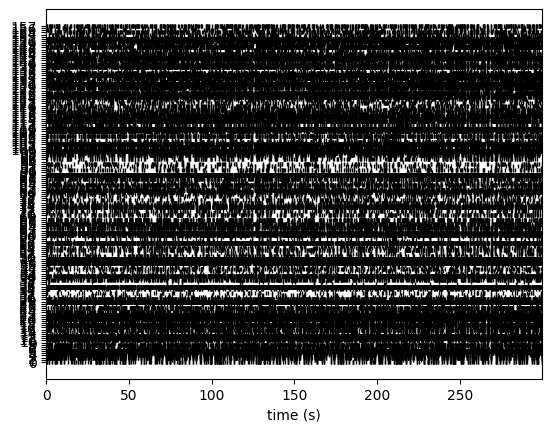

In [65]:
%matplotlib inline
w_rs = si.plot_rasters(sorting_KS25)

We can also save a spike sorting output for future use:

In [67]:
sorting_saved_KS25 = sorting_KS25.save(folder=base_folder / "sorting_KS25")

### Run sorter in container

Some sorters are hard to install! To alleviate this headache, SI provides a built-in mechanism to run a spike sorting job in a docker container.

We are maintaining a set of sorter-specific docker files in the [spikeinterface-dockerfiles repo](<https://github.com/SpikeInterface/spikeinterface-dockerfiles>)
and most of the docker images are available on Docker Hub from the [SpikeInterface organization](<https://hub.docker.com/orgs/spikeinterface/repositories>).

Running spike sorting in a docker container just requires to:

1. have docker/singularity installed
2. have docker/singularity python SDK installed (`pip install docker/spython`)

When docker/singularity is installed, you can simply run the sorter in a container image:

```python
# run spike sorting on entire recording
sorting_KS2 = si.run_sorter('kilosort2', recording_saved, 
                            output_folder=base_folder / 'sorter_KS2',
                            verbose=True,
                            docker_image=True, 
                            **job_kwargs)
```

In [69]:
sorting_KS2 = si.read_sorter_folder(base_folder / 'sorter_KS2')
sorting_KS2

KiloSortSortingExtractor: 170 units - 1 segments - 30.0kHz

In [60]:
# sorter_params = {'do_correction': False}
# sorting_KS4 = si.run_sorter('kilosort4', recording_saved, 
#                             output_folder=base_folder / 'sorter_KS4',
#                             verbose=True,
#                             **sorter_params)


In [61]:
# print(sorting_KS4)

In [61]:
# sorting_KS4 = sorting_KS4.remove_empty_units()
# print(f'KS2 found {len(sorting_KS2.get_unit_ids())} non-empty units')

# 5. Postprocessing and SortingAnalyzer <a class="anchor" id="sortinganalyzer"></a>

The core of postprocessing spike sorting results need to paired recording-sorting objects.

In the SI API, `SortingAnalyzer` class in the `core` module.

The `SortingAnalyzer` object handle a collection of extension to inspect the quality of the sorting:
  * waveforms
  * templates
  * spike amplitudes
  * quality metrics
  * ...



In [70]:
recording_saved = si.load_extractor(base_folder / "preprocessed")
sorting = sorting_KS25
print(sorting)

UnitsSelectionSorting: 157 units - 1 segments - 30.0kHz


In [71]:
analyzer = si.create_sorting_analyzer(sorting, recording_saved, sparse=True)
print(analyzer)

estimate_sparsity:   0%|          | 0/300 [00:00<?, ?it/s]

SortingAnalyzer: 64 channels - 157 units - 1 segments - memory - sparse - has recording
Loaded 0 extensions: 


Lets start with classical and minimal extension

In [72]:

analyzer.compute("random_spikes", method="uniform", max_spikes_per_unit=500)
analyzer.compute("waveforms", ms_before=1.2, ms_after=2.5)
analyzer.compute("templates", operators=["average", "std"])
analyzer.compute("noise_levels")

analyzer

compute_waveforms:   0%|          | 0/300 [00:00<?, ?it/s]

SortingAnalyzer: 64 channels - 157 units - 1 segments - memory - sparse - has recording
Loaded 4 extensions: random_spikes, waveforms, templates, noise_levels

Now all waveforms are computed and stored in the provided `waveforms` extension. We can now retrieve waveforms and templates easily:

In [73]:
wf_ext = analyzer.get_extension("waveforms")

In [75]:
waveforms0 = wf_ext.get_waveforms_one_unit(unit_id=0)
print(f"Waveforms shape: {waveforms0.shape}")
waveforms1 = wf_ext.get_waveforms_one_unit(unit_id=1)
print(f"Waveforms shape: {waveforms1.shape}")


Waveforms shape: (465, 111, 9)
Waveforms shape: (66, 111, 17)


In [76]:
template_ext = analyzer.get_extension("templates")

In [77]:
templates = template_ext.get_templates(operator="average")
print(templates.shape)


(157, 111, 64)




The `SortingAnalyzer` is also compatible with several `widgets` to visualize the spike sorting output:

We can also render interactive plots with the `ipywidgets` backend!

In [33]:
%matplotlib widget
w = si.plot_unit_templates(analyzer, backend="ipywidgets")

NameError: name 'analyzer' is not defined

## Sparsity

Especially when working with silicon high-density probes, or when our probe has multiple groups (e.g. multi-shank, tetrodes), we don't care about waveform/templates on all channels.

By default, the `SortingAnalyzer` use sparsity but here a way to set it manually with other options.



In [79]:
sparsity = si.estimate_sparsity?

Signature:
si.estimate_sparsity(
    recording: 'BaseRecording',
    sorting: 'BaseSorting',
    num_spikes_for_sparsity: 'int' = 100,
    ms_before: 'float' = 1.0,
    ms_after: 'float' = 2.5,
    method: "'radius' | 'best_channels'" = 'radius',
    peak_sign: 'str' = 'neg',
    radius_um: 'float' = 100.0,
    num_channels: 'int' = 5,
    **job_kwargs,
)
Docstring:
Estimate the sparsity without needing a SortingAnalyzer or Templates object
This is faster than  `spikeinterface.waveforms_extractor.precompute_sparsity()` and it
traverses the recording to compute the average templates for each unit.

Contrary to the previous implementation:
  * all units are computed in one read of recording
  * it doesn't require a folder
  * it doesn't consume too much memory
  * it uses internally the `estimate_templates_with_accumulator()` which is fast and parallel

Parameters
----------
recording: BaseRecording
    The recording
sorting: BaseSorting
    The sorting
num_spikes_for_sparsity: int, defa

In [80]:
sparsity = si.estimate_sparsity(recording_saved, sorting, num_spikes_for_sparsity=200, method="radius", radius_um=150.)
sparsity

estimate_sparsity:   0%|          | 0/300 [00:00<?, ?it/s]

ChannelSparsity - units: 157 - channels: 64 - density, P(x=1): 0.37

In [81]:
sparsity = si.estimate_sparsity(recording_saved, sorting, num_spikes_for_sparsity=200, method="radius", radius_um=250.)
sparsity

estimate_sparsity:   0%|          | 0/300 [00:00<?, ?it/s]

ChannelSparsity - units: 157 - channels: 64 - density, P(x=1): 0.37

In [82]:
sparsity = si.estimate_sparsity(recording_saved, sorting, num_spikes_for_sparsity=200, method="best_channels", num_channels=8)
sparsity


estimate_sparsity:   0%|          | 0/300 [00:00<?, ?it/s]

ChannelSparsity - units: 157 - channels: 64 - density, P(x=1): 0.12

In [83]:
for unit_id in sparsity.unit_ids[::30]:
    print(unit_id, list(sparsity.unit_id_to_channel_ids[unit_id]))

0 ['CH1', 'CH4', 'CH5', 'CH60', 'CH61', 'CH62', 'CH63', 'CH64']
30 ['CH10', 'CH12', 'CH17', 'CH23', 'CH29', 'CH37', 'CH46', 'CH54']
61 ['CH36', 'CH38', 'CH39', 'CH45', 'CH47', 'CH52', 'CH56', 'CH61']
91 ['CH10', 'CH17', 'CH34', 'CH37', 'CH41', 'CH46', 'CH49', 'CH51']
121 ['CH10', 'CH11', 'CH13', 'CH15', 'CH17', 'CH19', 'CH25', 'CH29']
151 ['CH12', 'CH16', 'CH23', 'CH24', 'CH26', 'CH31', 'CH32', 'CH46']


In [84]:
# we can use this sparsity object to create an other analyzer
analyzer_other_sparsity = si.create_sorting_analyzer(sorting, recording_saved, sparsity=sparsity)
analyzer_other_sparsity

SortingAnalyzer: 64 channels - 157 units - 1 segments - memory - sparse - has recording
Loaded 0 extensions: 

In [76]:
analyzer_other_sparsity.sparsity

ChannelSparsity - units: 157 - channels: 64 - density, P(x=1): 0.12

Most of the plotting and exporting functions accept `sparsity` as an argument. 

## Extensions tour

In [85]:
analyzer.get_computable_extensions()

['random_spikes',
 'waveforms',
 'templates',
 'fast_templates',
 'noise_levels',
 'amplitude_scalings',
 'correlograms',
 'isi_histograms',
 'principal_components',
 'spike_amplitudes',
 'spike_locations',
 'template_metrics',
 'template_similarity',
 'unit_locations',
 'quality_metrics']

### Spike amplitudes

Spike amplitudes can be computed with the `get_spike_amplitudes` function.

In [88]:
analyzer.compute("spike_amplitudes", **job_kwargs)

spike_amplitudes:   0%|          | 0/300 [00:00<?, ?it/s]

In [89]:
%matplotlib widget
w = si.plot_amplitudes(analyzer, backend="ipywidgets")

AppLayout(children=(VBox(children=(UnitSelector(children=(Label(value='Units', layout=Layout(justify_content='…

### Compute unit and spike locations

When using silicon probes, we can estimate the unit (or spike) location with triangulation. This can be done either with a simple center of mass or by assuming a monopolar model:

$$V_{ext}(\boldsymbol{r_{ext}}) = \frac{I_n}{4 \pi \sigma |\boldsymbol{r_{ext}} - \boldsymbol{r_{n}}|}$$

where $\boldsymbol{r_{n}}$ is the position of the neuron, and $\boldsymbol{r_{n}}$ of the electrode(s).

In [90]:
analyzer.compute("unit_locations", method="monopolar_triangulation")
analyzer.compute("spike_locations", method="center_of_mass", **job_kwargs)

spike_locations:   0%|          | 0/300 [00:00<?, ?it/s]

In [91]:
%matplotlib widget
w = si.plot_unit_locations(analyzer, backend="ipywidgets")

AppLayout(children=(UnitSelector(children=(Label(value='Units', layout=Layout(justify_content='center')), Sele…

In [85]:
%matplotlib widget
w = si.plot_spike_locations(analyzer, max_spikes_per_unit=300, backend="ipywidgets")

AppLayout(children=(UnitSelector(children=(Label(value='Units', layout=Layout(justify_content='center')), Sele…

## template similarity

In [92]:
analyzer.compute("template_similarity")

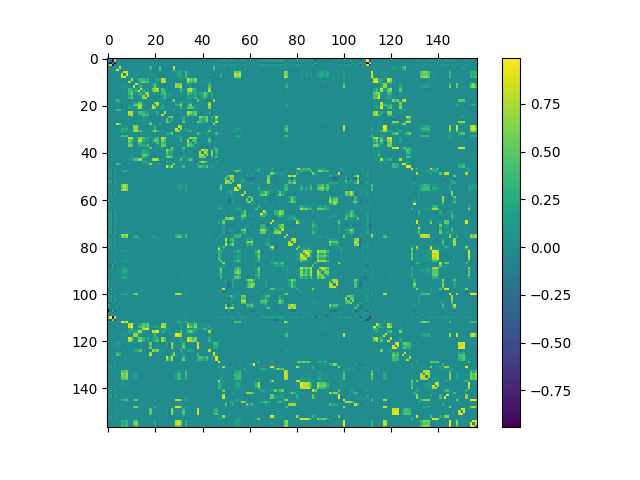

In [93]:
si.plot_template_similarity(analyzer)

### Compute correlograms

In [94]:
analyzer.compute("correlograms")

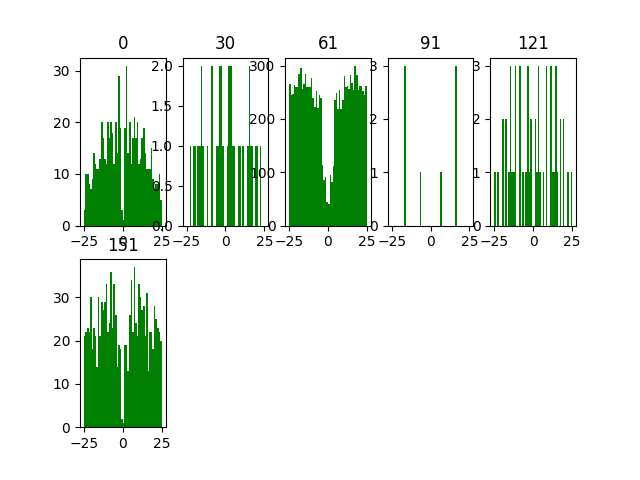

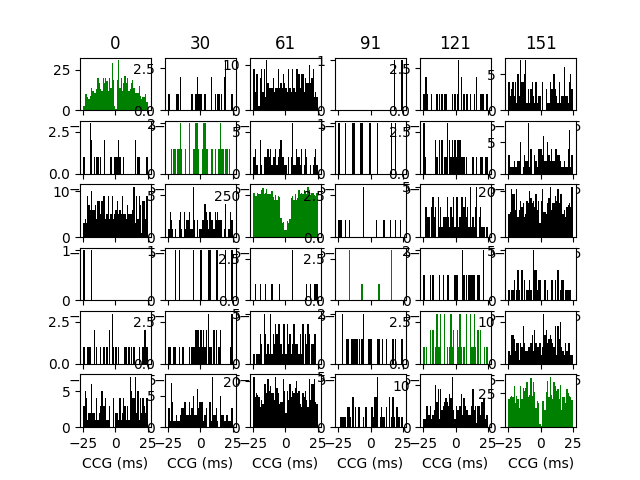

In [95]:
si.plot_autocorrelograms(analyzer, unit_ids=sorting.unit_ids[::30])
si.plot_crosscorrelograms(analyzer, unit_ids=sorting.unit_ids[::30])

### Principal components

PCA scores can be easily computed with the `"principal_components"` extension. Similarly to the `"waveforms"`, the function compute the components only on some random spikes.

Can be done with `si.compute_principal_components(analyzer, ...)` or `analyzer.compute("principal_components", ...)`


TODO : remove or not ????



In [86]:
si.compute_principal_components?

Signature:  
si.compute_principal_components(
    sorting_analyzer,
    load_if_exists=None,
    *args,
    **kwargs,
)
Type:        FuncWrapper
String form: <spikeinterface.core.sortinganalyzer.AnalyzerExtension.function_factory.<locals>.FuncWrapper object at 0x79031e5e4cd0>
File:        ~/Documents/SpikeInterface/spikeinterface/src/spikeinterface/core/sortinganalyzer.py
Docstring:  
Compute PC scores from waveform extractor. The PCA projections are pre-computed only
on the sampled waveforms available from the extensions "waveforms".

Parameters
----------
sorting_analyzer: SortingAnalyzer
    A SortingAnalyzer object
n_components: int, default: 5
    Number of components fo PCA
mode: "by_channel_local" | "by_channel_global" | "concatenated", default: "by_channel_local"
    The PCA mode:
        - "by_channel_local": a local PCA is fitted for each channel (projection by channel)
        - "by_channel_global": a global PCA is fitted for all channels (projection by channel)
        - "c

In [34]:
analyzer.compute("principal_components", n_components=3, mode="by_channel_global", **job_kwargs)
analyzer

NameError: name 'analyzer' is not defined

### Compute template metrics

Template metrics, or extracellular features, such as peak to valley duration or full-width half maximum, are important to classify neurons into putative classes (excitatory - inhibitory). The `postprocessing` allows one to compute several of these metrics:

In [96]:
print(si.get_template_metric_names())

['peak_to_valley', 'peak_trough_ratio', 'half_width', 'repolarization_slope', 'recovery_slope', 'num_positive_peaks', 'num_negative_peaks', 'velocity_above', 'velocity_below', 'exp_decay', 'spread']


In [97]:
# analyzer.compute("template_metrics")
template_metrics = si.compute_template_metrics(analyzer)
display(template_metrics)

,half_width,num_negative_peaks,num_positive_peaks,peak_to_valley,peak_trough_ratio,recovery_slope,repolarization_slope
0,0.00186,2,1,0.001277,-0.28143,-3038.274253,29524.018423
1,0.001977,2,2,0.00109,-0.349324,-25350.003475,77594.177392
2,0.00048,2,2,0.00087,-0.612785,-42756.839598,82906.25614
3,0.000577,1,2,0.001247,-0.336186,-10528.869654,38516.638004
4,0.000343,1,2,0.000973,-0.337388,-20294.411171,81643.014701
...,...,...,...,...,...,...,...
153,0.00026,1,2,0.000853,-0.234008,-22273.360156,177047.844842
154,0.000273,1,1,0.001057,-0.185751,-11030.959031,98173.629125
155,0.0003,1,1,0.00083,-0.334135,-22357.118487,144214.485424
156,0.000323,1,3,0.00083,-0.337677,-17171.5315,108648.551464


In [98]:
w = si.plot_template_metrics(analyzer, include_metrics=["peak_to_valley", "half_width"], backend="ipywidgets")

AppLayout(children=(UnitSelector(children=(Label(value='Units', layout=Layout(justify_content='center')), Sele…

For more information about these template metrics, we refer to this [documentation](https://github.com/AllenInstitute/ecephys_spike_sorting/tree/master/ecephys_spike_sorting/modules/mean_waveforms) from the Allen Institute.

# 6. Quality metrics and curation <a class="anchor" id="curation"></a>

The `qualitymetrics` module also provides several functions to compute qualitity metrics to validate the spike sorting results.

Let's see what metrics are available:

In [99]:
print(si.get_quality_metric_list())
print(si.get_quality_pca_metric_list())

['num_spikes', 'firing_rate', 'presence_ratio', 'snr', 'isi_violation', 'rp_violation', 'sliding_rp_violation', 'amplitude_cutoff', 'amplitude_median', 'amplitude_cv', 'synchrony', 'firing_range', 'drift', 'sd_ratio']
['isolation_distance', 'l_ratio', 'd_prime', 'nearest_neighbor', 'nn_isolation', 'nn_noise_overlap', 'silhouette']


In [100]:
metric_names = si.get_quality_metric_list()
qm = si.compute_quality_metrics(analyzer, metric_names=metric_names, verbose=True, **job_kwargs)


Computing amplitude_cutoff
Computing amplitude_cv
Computing amplitude_median
Computing drift
Computing firing_range
Computing firing_rate
Computing isi_violation
Computing num_spikes
Computing presence_ratio
Computing rp_violation
Computing sd_ratio
Computing sliding_rp_violation
Computing snr
Computing synchrony


In [95]:
display(qm)

,amplitude_cutoff,amplitude_cv_median,amplitude_cv_range,amplitude_median,drift_ptp,drift_std,drift_mad,firing_range,firing_rate,isi_violations_ratio,...,num_spikes,presence_ratio,rp_contamination,rp_violations,sd_ratio,sliding_rp_violation,snr,sync_spike_2,sync_spike_4,sync_spike_8
0,NaN,NaN,NaN,-20.670000,NaN,NaN,NaN,2.02,1.550000,3.699850,...,465.0,1.0,1.000000,3.0,1.613773,NaN,2.239948,0.156989,0.0,0.0
1,NaN,NaN,NaN,-43.972496,NaN,NaN,NaN,0.60,0.220000,0.000000,...,66.0,1.0,0.000000,0.0,2.010346,NaN,5.980886,0.363636,0.0,0.0
2,0.007644,0.428776,0.165055,-32.759998,0.894660,0.346854,0.313533,6.42,4.583333,3.808264,...,1375.0,1.0,1.000000,24.0,1.740695,NaN,4.692828,0.090182,0.0,0.0
3,0.001272,0.554838,0.224117,-26.519999,0.786377,0.255205,0.058384,9.25,6.776667,1.088774,...,2033.0,1.0,0.201830,5.0,1.853017,0.295,3.819015,0.057550,0.0,0.0
4,0.002120,0.382584,0.197191,-30.420000,0.625844,0.250127,0.205040,2.20,2.303333,0.209432,...,691.0,1.0,0.390326,1.0,2.062625,NaN,5.666526,0.047757,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,NaN,NaN,NaN,-60.254997,NaN,NaN,NaN,2.01,1.506667,0.978933,...,452.0,1.0,1.000000,2.0,1.491110,NaN,9.826928,0.024336,0.0,0.0
154,0.012866,0.247224,0.067639,-52.259998,0.762438,0.253300,0.153057,1.81,2.090000,0.000000,...,627.0,1.0,0.000000,0.0,1.485681,NaN,7.684842,0.038278,0.0,0.0
155,NaN,NaN,NaN,-47.384998,NaN,NaN,NaN,1.41,0.996667,1.118556,...,299.0,1.0,0.000000,0.0,2.515919,NaN,7.944482,0.056856,0.0,0.0
156,NaN,NaN,NaN,-37.634998,NaN,NaN,NaN,0.81,0.563333,0.000000,...,169.0,1.0,0.000000,0.0,1.749516,NaN,6.044827,0.059172,0.0,0.0


In [35]:
# TODO remove or not ???

si.plot_quality_metrics(analyzer, include_metrics=["amplitude_cutoff", "presence_ratio", "isi_violations_ratio", "snr"], backend="ipywidgets")

NameError: name 'analyzer' is not defined

For more information about these waveform features, we refer to the [SpikeInterface documentation](https://spikeinterface.readthedocs.io/en/latest/module_qualitymetrics.html) and to this excellent [documentation](https://allensdk.readthedocs.io/en/latest/_static/examples/nb/ecephys_quality_metrics.html) from the Allen Institute.

## Automatic curation based on quality metrics

In [36]:
# remove redundant units

A viable option to curate (or at least pre-curate) a spike sorting output is to filter units based on quality metrics. As we have already computed quality metrics a few lines above, we can simply filter the `qm` dataframe based on some thresholds.

Here, we'll only keep units with an ISI violation threshold < 0.2 and amplitude cutoff < 0.9:

In [102]:
isi_viol_thresh = 0.5
amp_cutoff_thresh = 0.1

A straightforward way to filter a pandas dataframe is via the `query`.
We first define our query (make sure the names match the column names of the dataframe):

In [103]:
our_query = f"amplitude_cutoff < {amp_cutoff_thresh} & isi_violations_ratio < {isi_viol_thresh}"
print(our_query)

amplitude_cutoff < 0.1 & isi_violations_ratio < 0.2


and then we can use the query to select units:

In [105]:
keep_units = qm.query(our_query)
keep_unit_ids = keep_units.index.values
keep_unit_ids

array([ 13,  16,  19,  23,  38,  48,  65,  88, 103, 113, 125, 126, 130,
       142, 154, 157])

In [106]:
sorting_auto_KS25 = sorting.select_units(keep_unit_ids)
print(f"Number of units before curation: {len(sorting.get_unit_ids())}")
print(f"Number of units after curation: {len(sorting_auto_KS25.get_unit_ids())}")

Number of units before curation: 157
Number of units after curation: 16


We can also save all the waveforms and post-processed data for curated units in a separate folder:

In [109]:
analyzer_curated = analyzer.select_units(keep_unit_ids)
analyzer_curated

SortingAnalyzer: 64 channels - 16 units - 1 segments - memory - sparse - has recording
Loaded 12 extensions: random_spikes, waveforms, templates, noise_levels, principal_components, spike_amplitudes, unit_locations, spike_locations, template_similarity, correlograms, template_metrics, quality_metrics

## save the analyzer

2 possible formats

In [111]:
analyzer.save_as(folder=base_folder/"analyzer_KS25", format="binary_folder")
analyzer_curated.save_as(folder=base_folder/"analyzer_KS25_curated.zarr", format="zarr")

SortingAnalyzer: 64 channels - 16 units - 1 segments - binary_folder - sparse - has recording
Loaded 12 extensions: random_spikes, waveforms, templates, noise_levels, principal_components, spike_amplitudes, unit_locations, spike_locations, template_similarity, correlograms, template_metrics, quality_metrics

In [112]:
analyzer_curated = si.load_sorting_analyzer(base_folder/"analyzer_KS25_curated.zarr")
analyzer_curated

SortingAnalyzer: 64 channels - 16 units - 1 segments - binary_folder - sparse - has recording
Loaded 12 extensions: templates, principal_components, random_spikes, template_metrics, correlograms, spike_locations, waveforms, quality_metrics, unit_locations, template_similarity, noise_levels, spike_amplitudes

# 7. Viewers <a class="anchor" id="viewers"></a>


### SpikeInterface GUI

A QT-based GUI built on top of SpikeInterface objects.

Developed by Samuel Garcia, CRNL, Lyon.

In [104]:
# !sigui {base_folder}/waveforms_sparse

In [113]:
%qt gui
si.plot_sorting_summary(analyzer_curated, backend="spikeinterface_gui")

### Sorting Summary - SortingView

The `sortingview` backend requires an additional step to configure the transfer of the data to be plotted to the cloud. 

See documentation [here](https://spikeinterface.readthedocs.io/en/latest/module_widgets.html).

Developed by Jeremy Magland and Jeff Soules, Flatiron Institute, NYC

In [114]:
w = si.plot_sorting_summary(analyzer_curated, backend="sortingview", curation=True)

https://figurl.org/f?v=gs://figurl/sortingview-11&d=sha1://7bf2a2c04a62c0d5245ba46222de9a4e6208e163


# 9. Spike sorting comparison <a class="anchor" id="comparison"></a>

Can we combine the output of multiple sorters to curate the spike sorting output?

To answer this question we can use the `comparison` module.
We first compare and match the output spike trains of the different sorters, and we can then extract a new `SortingExtractor` with only the units in agreement.

### Compare two sorters

In [108]:
comp_KS2_KS25 = si.compare_two_sorters(sorting_KS2, sorting_KS25, 'KS2', 'KS25')

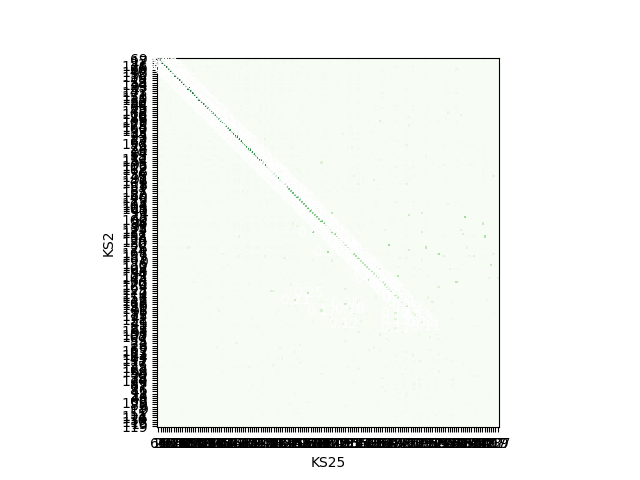

In [109]:
si.plot_agreement_matrix(comp_KS2_KS25)

In [110]:
comp_KS2_KS25auto = si.compare_two_sorters(sorting_KS2, sorting_auto_KS25, 'KS2', 'KS25_auto')

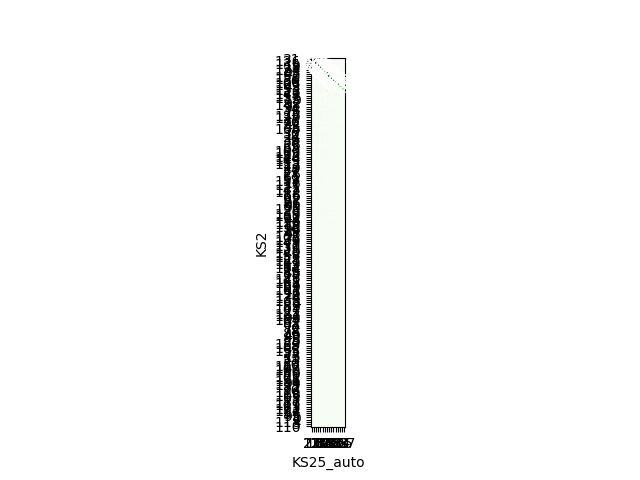

In [111]:
si.plot_agreement_matrix(comp_KS2_KS25auto)

### Compare multiple sorters

In [112]:
mcmp = si.compare_multiple_sorters([sorting_KS2, sorting_KS25], ['KS2', 'KS25'], 
                                   spiketrain_mode='union', verbose=True)

Multicomparison step 1: pairwise comparison
  Comparing: KS2 and KS25
Multicomparison step 2: make graph
Multicomparison step 3: clean graph
Removed 0 duplicate nodes
Multicomparison step 4: extract agreement from graph


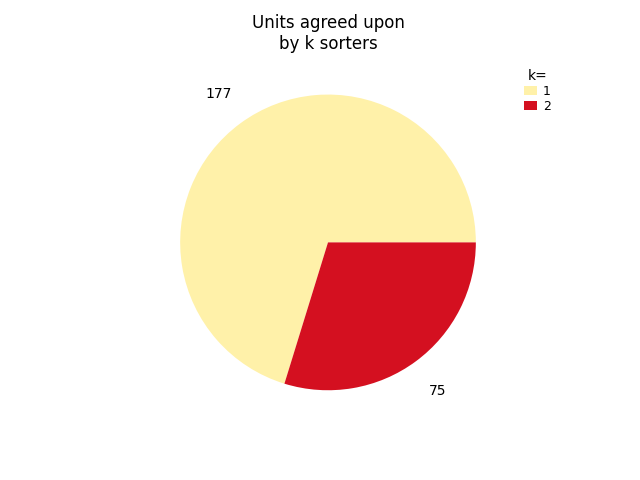

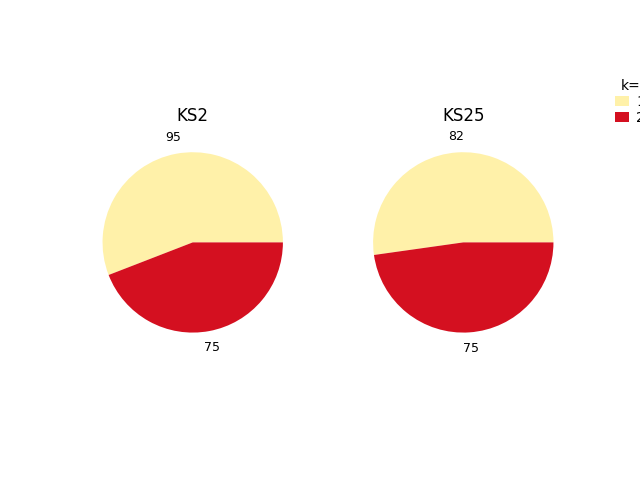

In [113]:
w = si.plot_multicomparison_agreement(mcmp)
w = si.plot_multicomparison_agreement_by_sorter(mcmp)

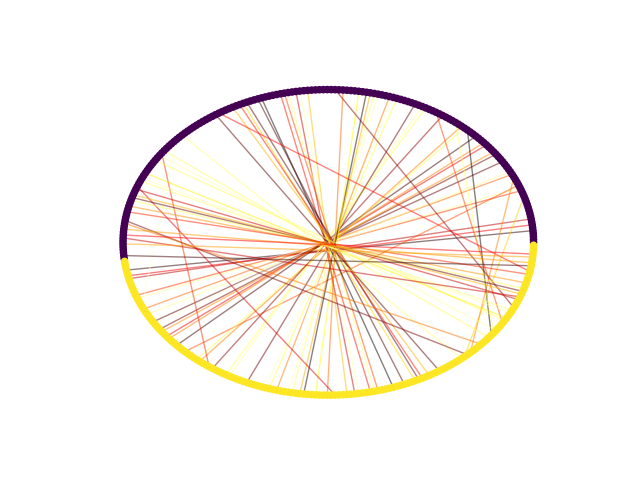

In [114]:
# REMOVE ???

si.plot_multicomparison_graph(mcmp, draw_labels=False)

In [115]:
# REMOVE ???

agreement_sorting = mcmp.get_agreement_sorting(minimum_agreement_count=2)
print(agreement_sorting)

AgreementSortingExtractor: 75 units - 1 segments - 30.0kHz


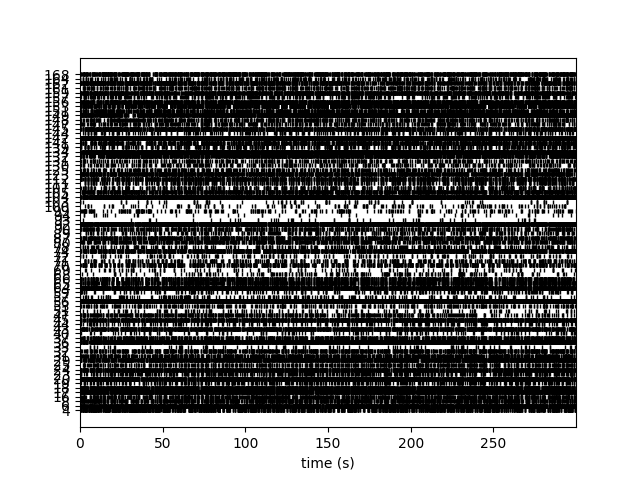

In [116]:
# REMOVE ???

si.plot_rasters(agreement_sorting)

In [117]:
# REMOVE ???

# compare consensus and auto
comp_agr_auto = si.compare_two_sorters(agreement_sorting, sorting_auto_KS25, 'AGR', 'AUTO')

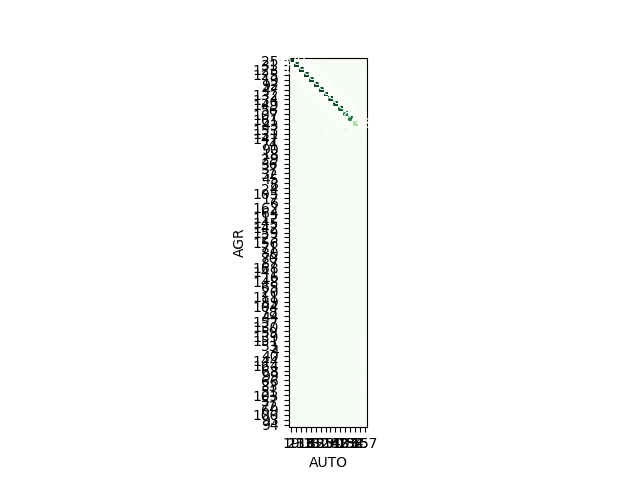

In [118]:
# REMOVE ???

si.plot_agreement_matrix(comp_agr_auto)

# 10. Exporters <a class="anchor" id="exporters"></a>

## Export to Phy for manual curation

To perform manual curation we can export the data to [Phy](https://github.com/cortex-lab/phy). 

In [119]:
si.export_to_phy?

Signature:
si.export_to_phy(
    sorting_analyzer: 'SortingAnalyzer',
    output_folder: 'str | Path',
    compute_pc_features: 'bool' = True,
    compute_amplitudes: 'bool' = True,
    sparsity: 'Optional[ChannelSparsity]' = None,
    copy_binary: 'bool' = True,
    remove_if_exists: 'bool' = False,
    peak_sign: "Literal['both', 'neg', 'pos']" = 'neg',
    template_mode: 'str' = 'median',
    dtype: 'Optional[npt.DTypeLike]' = None,
    verbose: 'bool' = True,
    use_relative_path: 'bool' = False,
    **job_kwargs,
)
Docstring:
Exports a waveform extractor to the phy template-gui format.

Parameters
----------
sorting_analyzer: SortingAnalyzer
    A SortingAnalyzer object
output_folder: str | Path
    The output folder where the phy template-gui files are saved
compute_pc_features: bool, default: True
    If True, pc features are computed
compute_amplitudes: bool, default: True
    If True, waveforms amplitudes are computed
sparsity: ChannelSparsity or None, default: None
    The s

In [120]:
si.export_to_phy(analyzer, output_folder=base_folder / 'phy_KS25', 
                   compute_amplitudes=False, compute_pc_features=False, copy_binary=False,
                   **job_kwargs)

Run:
phy template-gui  /home/samuel/DataSpikeSorting/Aussois_SI_tutorial/phy_KS25/params.py


After curating the results we can reload it using the `PhySortingExtractor` and exclude the units that we labeled as `noise`:

In [ ]:
sorting_phy_curated = se.PhySortingExtractor(base_folder / 'phy_KS25/', exclude_cluster_groups=['noise'])

## Export a report to a folder



In [122]:
si.export_report(analyzer_curated, output_folder=base_folder / 'report_KS25_curated')

### Et voilà!